In [7]:
import numpy as np
import math

rng1 = np.random.default_rng(seed=0)

def objective_function(x):
    """Keane's Bump function.
    n = dimension of the domain
    x = vector in the domain"""
    cos4 = 0
    cos2 = 1
    x_i = 0
    n = len(x)
    for i in range(n):
        cos4 += math.cos(x[i])**4
        cos2 *= math.cos(x[i])**2
        x_i += (i+1)*(x[i]**2)
    if x_i == 0:
        answer = None
    else:
        answer = np.abs((cos4 - 2*cos2)/math.sqrt(x_i))
    ## we are turning the maximization problem into a minimization problem
    return -1 * answer

def update_D(D, R):
    D =  0.9 * D + 0.21 * R
    min_step_size = 1e-3
    max_step_size = 1
    D = np.where(D < min_step_size, min_step_size, D)
    D = np.where(D > max_step_size, max_step_size, D)
    return D

def decrement_temperature_huang(T, accepted_solutions_at_T):
    alpha = max(0.5, np.exp(- 0.7 * T / np.std(accepted_solutions_at_T)))
    return T*alpha

def proposal(x, D, rng): ## Parks 1991
    while True:
        u = rng.uniform(-1, 1, size=len(x))
        x_new = x + np.dot(D, u)
        if np.all((x_new > 0) & (x_new < 10)):
            if np.sum(x_new) < 15 * len(x) / 2 and np.prod(x_new) > 0.75:
                break
    return x_new, u

def archive_function(x, archive, unchanged_counter):
    ## 10 best solutions 
    archive_limit = 10
    f = objective_function(x)
    if len(archive) < archive_limit:
        archive.append((x, f))
    else:
        archive.append((x, f))  # Update all elements
        archive.sort(key=lambda item: item[1])  # Sort the archive by objective function value
        archive = archive[:archive_limit]  # Keep only the top elements
    if np.array_equal(archive[0][0],x): ## if current solution is the best solution in archive, reset counter
        unchanged_counter = 0
    else:
        unchanged_counter += 1
    return archive, unchanged_counter

def find_Tin_White(Lk, n, rng): ## White 1984
    Tin = []
    for i in range(25):
        while True:
            x = np.random.uniform(0, 10, size=n)
            if np.all((x > 0) & (x < 10)):
                if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
                    break
        D = np.identity(n)
        acceptanced_objectives = []
        for j in range(Lk):
            u = rng.uniform(-1, 1, size=n)
            x_new = x + np.dot(D, u)
            delta = objective_function(x_new) - objective_function(x)
            R = np.abs(np.diag(np.dot(D, u)))
            acceptanced_objectives.append(delta)
            x = x_new
            D = update_D(D, R)
        Tin.append(np.std(acceptanced_objectives))
    return np.average(Tin)

def find_Tin_kirkpatrick(Lk, n, rng): ## Kirkpatrick 1984
    Tin = []
    for i in range(50):
        while True:
            x = np.random.uniform(0, 10, size=n)
            if np.all((x > 0) & (x < 10)):
                if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
                    break
        D = np.identity(n)
        accepted_deltas = []
        for j in range(Lk):
            u = rng.uniform(-1, 1, size=n)
            x_new = x + np.dot(D, u)
            delta = objective_function(x_new) - objective_function(x)
            R = np.abs(np.diag(np.dot(D, u)))
            if delta > 0:
                accepted_deltas.append(delta)
            x = x_new
            D = update_D(D, R)
        Tin.append(-1 * np.sum(accepted_deltas) / math.log(0.8))
    return np.average(Tin)

def main(x0, Lk, rng):
    x_prev = x0
    # T = find_Tin_White(Lk, len(x0), rng)
    T = find_Tin_kirkpatrick(Lk, len(x0), rng)
    # print(f"Initial temperature: {T}")
    Din = np.identity(len(x0))
    D = Din
    accepted_solutions = []
    archive = []
    counter =  0
    max_iter = 15000
    alpha = 0.95
    unchanged_counter = 0
    unchanged_threshold = 5000
    while counter < max_iter and unchanged_counter < unchanged_threshold:
        acceptances_at_T = 0
        accepted_solutions_at_T = []
        for i in range(Lk):
            x_new, u = proposal(x_prev, Din, rng)
            counter += 1
            R = np.abs(np.diag(np.dot(D, u)))
            delta = objective_function(x_new) - objective_function(x_prev)
            if delta < 0:
                x_prev = x_new
                acceptances_at_T += 1
                accepted_solutions.append(x_new)
                accepted_solutions_at_T.append(x_new)
                D = update_D(D, R)
                archive, unchanged_counter = archive_function(x_new, archive, unchanged_counter)
            else:
                step_size = np.sqrt(np.sum(R**2))
                p = np.exp(- (0.7 * delta) / (T * step_size))
                if rng.uniform() < p:
                    x_prev = x_new
                    acceptances_at_T += 1
                    accepted_solutions.append(x_new)
                    accepted_solutions_at_T.append(x_new)
                    D = update_D(D, R)
                    archive, unchanged_counter = archive_function(x_new, archive, unchanged_counter)
                else:
                    unchanged_counter += 1
            if acceptances_at_T / Lk >= 0.6:
                break
        # T = decrement_temperature(T, alpha)
        T = decrement_temperature_huang(T, accepted_solutions_at_T)
        # print(f"New temperature: {T}, acceptances at previous T: {acceptances_at_T/ Lk}, counter: {counter}")
    return accepted_solutions, archive

Change Lk and See The Effects when Huang Cooling and Kirkpatrick initial Temperature is used

In [8]:
def run_simulation(Lk):
    n = 8 ## 2D
    while True:
        x = np.random.uniform(0, 10, size=n)
        if np.all((x > 0) & (x < 10)):
            if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
                break
    accepted_solutions, archive = main(x, Lk, rng1)
    return archive[0][0], archive[0][1]

Lks = [25, 50, 75, 100, 125, 150, 175, 200, 500]

for Lk in Lks:
    objectives = []
    best_objective = 0
    for i in range(25):
        x, f = run_simulation(Lk)
        best_objective += f
    objectives.append(best_objective/25)
    print(f"Best objective for Lk = {Lk}: {objectives[0]}")

print(objectives)

Best objective for Lk = 25: -0.4915467791388222
Best objective for Lk = 50: -0.5416935034765307
Best objective for Lk = 75: -0.5603575166616093
Best objective for Lk = 100: -0.5457855120104773
Best objective for Lk = 125: -0.45771576442869333
Best objective for Lk = 150: -0.4578338762286447
Best objective for Lk = 175: -0.4816502847012059
Best objective for Lk = 200: -0.43520932013153363
Best objective for Lk = 500: -0.33193338712752335
[-0.33193338712752335]


In [ ]:
Lks = [25, 50, 75, 100, 125, 150, 175, 200, 500]
objectives = [-0.4915467791388222, -0.5416935034765307, -0.5603575166616093, -0.5457855120104773, -0.45771576442869333,  -0.4578338762286447, -0.4816502847012059, -0.43520932013153363, -0.33193338712752335]

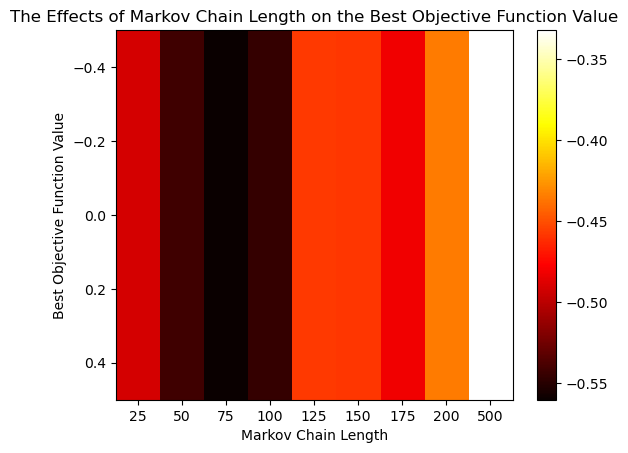

In [15]:
import numpy as np
# can you make a heatmap of the best objective function value for each Lk?
import matplotlib.pyplot as plt
# Define the Lk values and the corresponding best objective function values
Lks = [25, 50, 75, 100, 125, 150, 175, 200, 500]
objectives = [-0.4915467791388222, -0.5416935034765307, -0.5603575166616093, -0.5457855120104773, -0.45771576442869333, -0.4578338762286447, -0.4816502847012059, -0.43520932013153363, -0.33193338712752335]

# Convert the lists to numpy arrays
Lks_array = np.array(Lks)
objectives_array = np.array(objectives)

# Reshape the objectives array to a 2D array
objectives_2d = objectives_array.reshape(1, -1)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the heatmap
heatmap = ax.imshow(objectives_2d, cmap='hot', aspect='auto')

# Set the ticks and labels for the x-axis
ax.set_xticks(np.arange(len(Lks)))
ax.set_xticklabels(Lks)

# Set the labels for the x-axis and y-axis
ax.set_xlabel('Markov Chain Length')
ax.set_ylabel('Best Objective Function Value')

# Add a colorbar
cbar = fig.colorbar(heatmap)

# Show the plot
plt.title("The Effects of Markov Chain Length on the Best Objective Function Value")
plt.show()


See the effects of changing Lk for the Simple Cooling Scheme (as opposed to the Huang one) and the Kirkpatrick starting temperature

In [16]:
import numpy as np
import math

rng1 = np.random.default_rng(seed=0)

def objective_function(x):
    """Keane's Bump function.
    n = dimension of the domain
    x = vector in the domain"""
    cos4 = 0
    cos2 = 1
    x_i = 0
    n = len(x)
    for i in range(n):
        cos4 += math.cos(x[i])**4
        cos2 *= math.cos(x[i])**2
        x_i += (i+1)*(x[i]**2)
    if x_i == 0:
        answer = None
    else:
        answer = np.abs((cos4 - 2*cos2)/math.sqrt(x_i))
    ## we are turning the maximization problem into a minimization problem
    return -1 * answer

def update_D(D, R):
    D =  0.9 * D + 0.21 * R
    min_step_size = 1e-3
    max_step_size = 1
    D = np.where(D < min_step_size, min_step_size, D)
    D = np.where(D > max_step_size, max_step_size, D)
    return D

def decrement_temperature_huang(T, accepted_solutions_at_T):
    alpha = max(0.5, np.exp(- 0.7 * T / np.std(accepted_solutions_at_T)))
    return T*alpha

def decrement_temperature(T, alpha):
    return T*alpha

def proposal(x, D, rng): ## Parks 1991
    while True:
        u = rng.uniform(-1, 1, size=len(x))
        x_new = x + np.dot(D, u)
        if np.all((x_new > 0) & (x_new < 10)):
            if np.sum(x_new) < 15 * len(x) / 2 and np.prod(x_new) > 0.75:
                break
    return x_new, u

def archive_function(x, archive, unchanged_counter):
    ## 10 best solutions 
    archive_limit = 10
    f = objective_function(x)
    if len(archive) < archive_limit:
        archive.append((x, f))
    else:
        archive.append((x, f))  # Update all elements
        archive.sort(key=lambda item: item[1])  # Sort the archive by objective function value
        archive = archive[:archive_limit]  # Keep only the top elements
    if np.array_equal(archive[0][0],x): ## if current solution is the best solution in archive, reset counter
        unchanged_counter = 0
    else:
        unchanged_counter += 1
    return archive, unchanged_counter

def find_Tin_White(Lk, n, rng): ## White 1984
    Tin = []
    for i in range(25):
        while True:
            x = np.random.uniform(0, 10, size=n)
            if np.all((x > 0) & (x < 10)):
                if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
                    break
        D = np.identity(n)
        acceptanced_objectives = []
        for j in range(Lk):
            u = rng.uniform(-1, 1, size=n)
            x_new = x + np.dot(D, u)
            delta = objective_function(x_new) - objective_function(x)
            R = np.abs(np.diag(np.dot(D, u)))
            acceptanced_objectives.append(delta)
            x = x_new
            D = update_D(D, R)
        Tin.append(np.std(acceptanced_objectives))
    return np.average(Tin)

def find_Tin_kirkpatrick(Lk, n, rng): ## Kirkpatrick 1984
    Tin = []
    for i in range(50):
        while True:
            x = np.random.uniform(0, 10, size=n)
            if np.all((x > 0) & (x < 10)):
                if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
                    break
        D = np.identity(n)
        accepted_deltas = []
        for j in range(Lk):
            u = rng.uniform(-1, 1, size=n)
            x_new = x + np.dot(D, u)
            delta = objective_function(x_new) - objective_function(x)
            R = np.abs(np.diag(np.dot(D, u)))
            if delta > 0:
                accepted_deltas.append(delta)
            x = x_new
            D = update_D(D, R)
        Tin.append(-1 * np.sum(accepted_deltas) / math.log(0.8))
    return np.average(Tin)

def main(x0, Lk, rng):
    x_prev = x0
    # T = find_Tin_White(Lk, len(x0), rng)
    T = find_Tin_kirkpatrick(Lk, len(x0), rng)
    # print(f"Initial temperature: {T}")
    Din = np.identity(len(x0))
    D = Din
    accepted_solutions = []
    archive = []
    counter =  0
    max_iter = 15000
    alpha = 0.95
    unchanged_counter = 0
    unchanged_threshold = 5000
    while counter < max_iter and unchanged_counter < unchanged_threshold:
        acceptances_at_T = 0
        accepted_solutions_at_T = []
        for i in range(Lk):
            x_new, u = proposal(x_prev, Din, rng)
            counter += 1
            R = np.abs(np.diag(np.dot(D, u)))
            delta = objective_function(x_new) - objective_function(x_prev)
            if delta < 0:
                x_prev = x_new
                acceptances_at_T += 1
                accepted_solutions.append(x_new)
                accepted_solutions_at_T.append(x_new)
                D = update_D(D, R)
                archive, unchanged_counter = archive_function(x_new, archive, unchanged_counter)
            else:
                step_size = np.sqrt(np.sum(R**2))
                p = np.exp(- (0.7 * delta) / (T * step_size))
                if rng.uniform() < p:
                    x_prev = x_new
                    acceptances_at_T += 1
                    accepted_solutions.append(x_new)
                    accepted_solutions_at_T.append(x_new)
                    D = update_D(D, R)
                    archive, unchanged_counter = archive_function(x_new, archive, unchanged_counter)
                else:
                    unchanged_counter += 1
            if acceptances_at_T / Lk >= 0.6:
                break
        T = decrement_temperature(T, alpha)
        # T = decrement_temperature_huang(T, accepted_solutions_at_T)
        # print(f"New temperature: {T}, acceptances at previous T: {acceptances_at_T/ Lk}, counter: {counter}")
    return accepted_solutions, archive

In [17]:
def run_simulation(Lk):
    n = 8 ## 2D
    while True:
        x = np.random.uniform(0, 10, size=n)
        if np.all((x > 0) & (x < 10)):
            if np.sum(x) < 15 * n / 2 and np.prod(x) > 0.75:
                break
    accepted_solutions, archive = main(x, Lk, rng1)
    return archive[0][0], archive[0][1]

Lks = [25, 50, 75, 100, 125, 150, 175, 200, 500]
objectives = []
for Lk in Lks:
    best_objective = 0
    for i in range(25):
        x, f = run_simulation(Lk)
        best_objective += f
    objectives.append(best_objective/25)
    print(f"Best objective for Lk = {Lk}: {objectives[-1]}")

print(objectives)

Best objective for Lk = 25: -0.46488202903512915
Best objective for Lk = 50: -0.5202832060358437
Best objective for Lk = 75: -0.5075105487438519
Best objective for Lk = 100: -0.4996873331578908
Best objective for Lk = 125: -0.46953860102342887
Best objective for Lk = 150: -0.4391394230108308
Best objective for Lk = 175: -0.3999891521566861
Best objective for Lk = 200: -0.34234986312569515
Best objective for Lk = 500: -0.3261798680169089
[-0.46488202903512915, -0.5202832060358437, -0.5075105487438519, -0.4996873331578908, -0.46953860102342887, -0.4391394230108308, -0.3999891521566861, -0.34234986312569515, -0.3261798680169089]


In [18]:
Lks = [25, 50, 75, 100, 125, 150, 175, 200, 500]
objectives = [-0.46488202903512915, -0.5202832060358437, -0.5075105487438519, -0.4996873331578908, -0.46953860102342887, -0.4391394230108308, -0.3999891521566861, -0.34234986312569515, -0.3261798680169089]

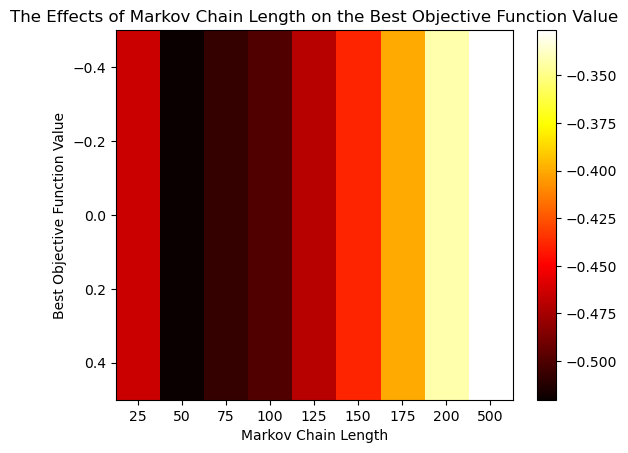

In [19]:
import numpy as np
# can you make a heatmap of the best objective function value for each Lk?
import matplotlib.pyplot as plt

# Convert the lists to numpy arrays
Lks_array = np.array(Lks)
objectives_array = np.array(objectives)

# Reshape the objectives array to a 2D array
objectives_2d = objectives_array.reshape(1, -1)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the heatmap
heatmap = ax.imshow(objectives_2d, cmap='hot', aspect='auto')

# Set the ticks and labels for the x-axis
ax.set_xticks(np.arange(len(Lks)))
ax.set_xticklabels(Lks)

# Set the labels for the x-axis and y-axis
ax.set_xlabel('Markov Chain Length')
ax.set_ylabel('Best Objective Function Value')

# Add a colorbar
cbar = fig.colorbar(heatmap)

# Show the plot
plt.title("The Effects of Markov Chain Length on the Best Objective Function Value")
plt.show()
